### Test the rarely switching LinUCB bandit

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)

from lib.bandits import LinUCB, ThresholdBandit,GreedyBandit, ThresholdBaselineBandit, RarelySwitchingLinUCB, ConsLinUCB, expected_regret
from lib.generator import LinearGeneratorParams, LinearGenerator
import numpy as np 

import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import seaborn as sns
sns.set_style('ticks')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/home/lansdell/.local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
#alg = 'greedy'
#alg = 'linucb'
#alg = 'threshold'
#alg = 'thresholdcons'
#alg = 'conslinucb'
#alg = 'thrbaseline'
alg = 'rarelyswitching'

M = 3    #number of runs
N = 10000 #number of timesteps
save = False
max_alpha = 2
max_beta = 2
k = 4    #Number of arms
d = 5   #Dimension of context (includes one dim for intercept term)
intercept = True
evaluate_every = 100

if alg == 'greedy':
	BanditAlg = GreedyBandit
elif alg == 'linucb':
	BanditAlg = LinUCB
elif alg == 'threshold':
	BanditAlg = ThresholdBandit
elif alg == 'thresholdcons':
	BanditAlg = ThresholdConsBandit
elif alg == 'conslinucb':
	BanditAlg = ConsLinUCB
elif alg == 'thrbaseline':
	BanditAlg = ThresholdBaselineBandit
elif alg == 'rarelyswitching':
	BanditAlg = RarelySwitchingLinUCB
else:
	print "Select a valid algorithm"

## Run rarely switching bandit 

In [6]:
#Generate slopes and intercepts
alphas = truncnorm.rvs(-max_alpha, max_alpha, scale = 1, size=(M,k,d-1))
betas = truncnorm.rvs(-max_beta, max_beta, scale = 1, size=(M,k))

regret = np.zeros((M, N))
expt_regret = np.zeros((M, N))
arm_pulls = np.zeros((M, N, k+1))
n_changes = np.zeros((M, N))
update_pol = np.zeros((M, N))

In [8]:
print("Running %s algorithm"%alg)

for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    bandit = BanditAlg(generator, delta = 1./N)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        #print(ctx, arm_idx)
        regret[m,i] = r
        if arm_idx >= 0:
            arm_pulls[m,i,arm_idx] = 1
        else:
            arm_pulls[m,i,k] = 1

Running rarelyswitching algorithm
Run: 1/3
Run: 2/3
Run: 3/3


## LinUCB for comparison

In [9]:
BanditAlg = LinUCB    
regret_linucb = np.zeros((M, N))
arm_pulls_linucb = np.zeros((M, N, k+1))

In [10]:
for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    bandit = BanditAlg(generator)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        #print(ctx, arm_idx)
        regret_linucb[m,i] = r
        if arm_idx >= 0:
            arm_pulls_linucb[m,i,arm_idx] = 1
        else:
            arm_pulls_linucb[m,i,k] = 1

Run: 1/3
Run: 2/3
Run: 3/3


## ThrGreedy for comparison

In [22]:
BanditAlg = ThresholdBandit    
regret_thrgr = np.zeros((M, N))
arm_pulls_thrgr = np.zeros((M, N, k+1))

In [23]:
for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    bandit = BanditAlg(generator)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        #print(ctx, arm_idx)
        regret_thrgr[m,i] = r
        if arm_idx >= 0:
            arm_pulls_thrgr[m,i,arm_idx] = 1
        else:
            arm_pulls_thrgr[m,i,k] = 1

Run: 1/3
Run: 2/3
Run: 3/3


## Comparison of the two methods

Trade-off between convergence rate, risk, and confidence level

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


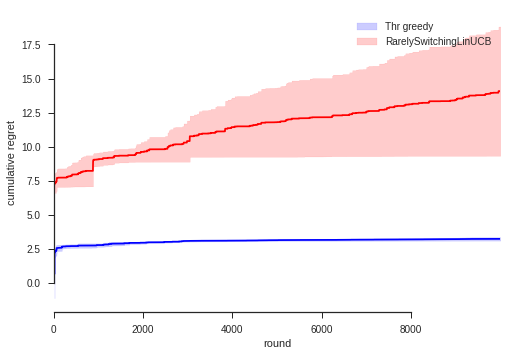

In [25]:
#Vary the confidence level, plot convergence rate, regret, risk
#sns.tsplot(np.log(np.cumsum(regret, axis = 1)), color = 'red')
sns.tsplot(np.log(np.cumsum(regret_thrgr, axis = 1)), color = 'blue')
sns.tsplot(np.cumsum(regret, axis = 1), color = 'red')
plt.xlabel('round')
plt.ylabel('cumulative regret')
plt.legend(['Thr greedy', 'RarelySwitchingLinUCB'])
sns.despine(trim = True)

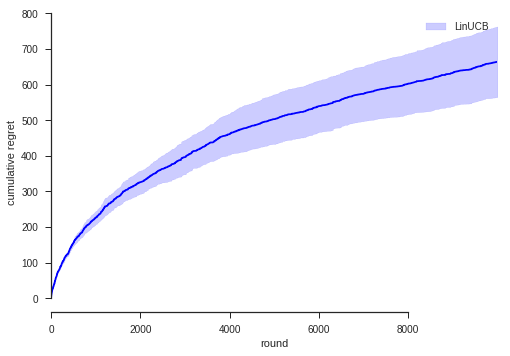

In [20]:
sns.tsplot(np.cumsum(regret_linucb, axis = 1), color = 'blue')
plt.xlabel('round')
plt.ylabel('cumulative regret')
plt.legend(['LinUCB'])
sns.despine(trim = True)